# Implémentez un modèle de scoring


Etude data - Projet 7 - Mars 2021

*Data source* : [Jeu de données d’articles](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip)

---

## Rappel de la mission
Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

## Code de la modélisation
Dans le Notebook Jupyter nous avons vu l'exploration, ainsi que le prétraitement des données. Ici nous utiliserons un GPU pour effectuer les modélisations Catboost, LightGBM & XGBoost. Ici nous sommes en Google Colab PRO, donc l'accès au GPU est illimité… _L'offre free ne permet pas de mener à bien ce projet, les limites ont rapidement étaient atteintes pour effectuer les différents tests._


In [1]:
#Test de l'activation du GPU
#Si le GPU est activé, il donnera la sortie suivante - '/ device: GPU: 0 '
import tensorflow as tf
tf.test.gpu_device_name ()

'/device:GPU:0'

In [ ]:
#Appareils utilisés lors de l'exécution du notebook dans le cloud
from tensorflow.python.client import device_lib 
device_lib.list_local_devices ()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16360478728543910270, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15505193728
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 678723616778043399
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"]

In [ ]:
#Vérification de la RAM
!cat /proc/meminfo

MemTotal:       26751704 kB
MemFree:        18582216 kB
MemAvailable:   24089964 kB
Buffers:          117536 kB
Cached:          2523264 kB
SwapCached:            0 kB
Active:          2782092 kB
Inactive:        4980908 kB
Active(anon):    2009992 kB
Inactive(anon):      408 kB
Active(file):     772100 kB
Inactive(file):  4980500 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               580 kB
Writeback:             0 kB
AnonPages:       5122172 kB
Mapped:           268032 kB
Shmem:              1012 kB
Slab:             220652 kB
SReclaimable:     155804 kB
SUnreclaim:        64848 kB
KernelStack:        5632 kB
PageTables:        16380 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    13375852 kB
Committed_AS:    8723632 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:             2096 kB
AnonHugePages:   

---

In [1]:
pip install catboost 

     |████████████████████████████████| 67.3MB 86kB/s 


In [2]:
!git clone --recursive https://github.com/Microsoft/LightGBM

Cloning into 'LightGBM'...
remote: Enumerating objects: 21795, done.
remote: Counting objects: 100% (287/287), done.
remote: Compressing objects: 100% (181/181), done.
remote: Total 21795 (delta 156), reused 189 (delta 101), pack-reused 21508
Receiving objects: 100% (21795/21795), 17.19 MiB | 23.43 MiB/s, done.
Resolving deltas: 100% (15908/15908), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused

In [3]:
!cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Looking for CL_VERSION_2_2
-- Looking for CL_VERSION_2_2 - found
-- Found OpenCL: /usr/lib/x86_64-linux-gnu/libOpenCL.so (found version "2.2") 
-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--

In [5]:
import pandas as pd
import seaborn as sns
import time, pickle

from zipfile import ZipFile

#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, learning_curve, cross_validate
from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings("ignore")

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':15,
     'ytick.labelsize':15,
     'axes.labelsize': 15,
     'legend.fontsize': 15,
     'axes.titlesize':15,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })

In [8]:
#Download files from google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
#Second solution >>> import files from your computer
#from google.colab import files
#uploaded = files.upload()
#for fn in uploaded.keys():
#  print('Vous avez importé le fichier "{name}" qui a une taille de {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Mounted at /content/gdrive


In [9]:
z = ZipFile("/content/gdrive/My Drive/Colab Notebooks/p7_00_data/data_train.zip")
data_train = pd.read_csv(z.open('data_train.csv'), index_col='SK_ID_CURR', encoding ='utf-8')
#data_train.drop('SK_ID_CURR', axis=1, inplace=True)
data_train.shape

(307511, 309)

In [10]:
TARGET = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/p7_00_data/TARGET.csv', index_col='SK_ID_CURR')
TARGET.shape

(307511, 1)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data_train.values, TARGET.values, test_size=0.3, random_state=42)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((215257, 309), (92254, 309), (215257, 1), (92254, 1))

### **Baseline model - Logistic Regression**
Le projet consiste à mieux comprendre le défaut de crédit rencontré chez certain client, l'anticiper, l'estimer, etc… La prédiction peut se résumer par une sortie binaire, une acceptation de crédit, ou un refus de crédit. Afin d'avoir une première idée des performances possibles, la modélisation par régression logistique permettra d'obtenir une baseline.

In [13]:
from sklearn.linear_model import LogisticRegression

In [16]:
def cf_matrix_roc_auc(model, y_true, y_pred, y_pred_proba, feature_importances):
    '''This function will make a pretty plot of 
  an sklearn Confusion Matrix using a Seaborn heatmap visualization + ROC Curve.'''
    fig = plt.figure(figsize=(20,15))
  
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    plt.subplot(222)
    fpr,tpr,_ = roc_curve(y_true, y_pred_proba)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label='AUC = %0.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    if feature_importances : 
        plt.subplot(212)
        indices = np.argsort(model.feature_importances_)[::-1]
    
    features = []
    for i in range(20):
        features.append(X_data.columns[indices[i]]) #After RFECV selection > X_data created

    sns.barplot(x=features, y=model.feature_importances_[indices[range(20)]], color=("orange"))
    plt.xlabel('Features importance')
    plt.xticks(rotation=90)

    show()

In [14]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.6939
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       0.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254

CPU times: user 7.72 s, sys: 2.47 s, total: 10.2 s
Wall time: 2.72 s


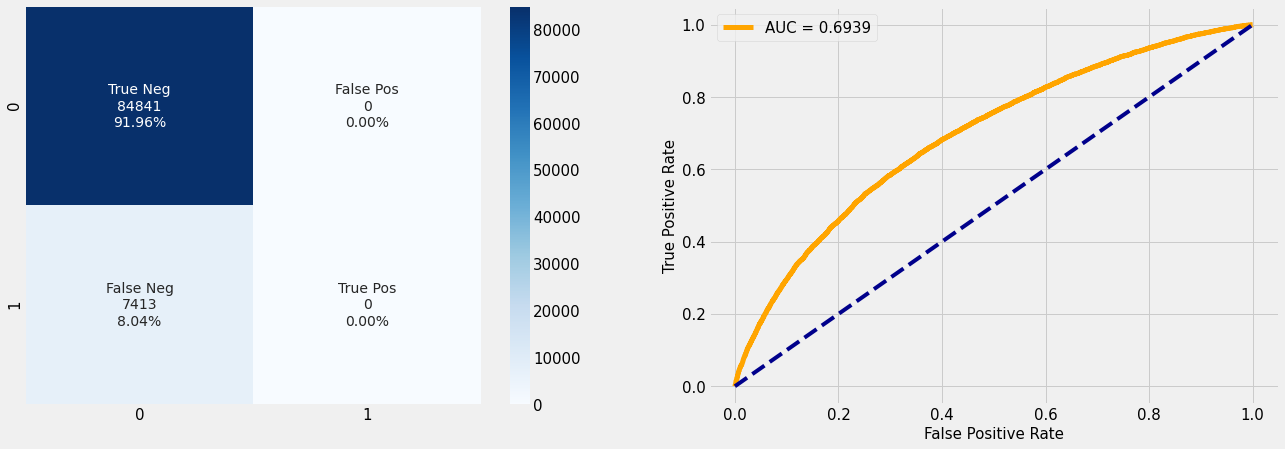

In [17]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None)

Notons un fort déséquilibre entre la précision trouvée pour la Target 0 (0.92) et la Target 1 (0). Pour rappel, l'échantillon de travail n'est pas équilibré, avec 92% des individus classés en modalité 0 et 8% en modalité 1, à savoir en défaut de paiement de crédit..

Il est donc intéressant de travailler cet Oversampling (ou suréchantillonnage en français)  en ajustant la distribution de classe de manière à avoir une répartition plus égalitaire.

**Oversampling Data Using SMOTE**

SMOTE with Imbalance Data using imblearn module



In [18]:
print("Label 1, Before using SMOTE: {} ".format(sum(y_train==1)))
print("Label 0, Before using SMOTE: {} ".format(sum(y_train==0)))

Label 1, Before using SMOTE: 17412 
Label 0, Before using SMOTE: 197845 


In [19]:
%%time
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

CPU times: user 3min 9s, sys: 578 ms, total: 3min 10s
Wall time: 3min 9s


In [20]:
print("Label 1, After using SMOTE: {}".format(sum(y_train_res==1)))
print("Label 0, After using SMOTE: {}".format(sum(y_train_res==0)))

Label 1, After using SMOTE: 197845
Label 0, After using SMOTE: 197845


In [21]:
%%time
lr = LogisticRegression(C = 0.0001, max_iter=100)
lr.fit(X_train_res, y_train_res)
roc_auc = roc_auc_score(y_test, lr.predict_proba(X_test)[:,1])
print('AUC : %0.4f' %roc_auc)
print(classification_report(y_test, lr.predict(X_test)))

AUC : 0.7196
              precision    recall  f1-score   support

         0.0       0.96      0.67      0.79     84841
         1.0       0.15      0.65      0.24      7413

    accuracy                           0.67     92254
   macro avg       0.55      0.66      0.52     92254
weighted avg       0.89      0.67      0.75     92254

CPU times: user 31.3 s, sys: 8.46 s, total: 39.7 s
Wall time: 10.2 s


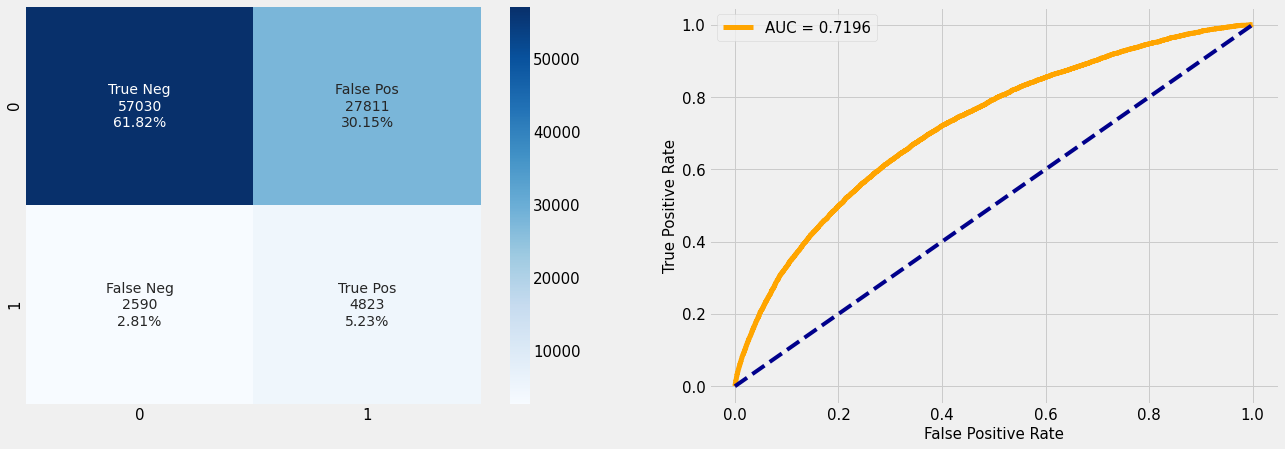

In [22]:
cf_matrix_roc_auc(lr, y_test, lr.predict(X_test), lr.predict_proba(X_test)[:,1], feature_importances=None)

Amélioration de l'AUC score 0.72 que nous prendrons comme baseline de travail pour la suite des essais…

### **Gradient Boosting**

In [23]:
#Predictive Models
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

models = [
          CatBoostClassifier(task_type="GPU", logging_level='Silent'),
          LGBMClassifier(device='gpu'),
          XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')]

La fonction suivante ``train_models`` peut calculer les métriques auc, accuracy, f1, precision et recall. On peut la modifier selon les besoins attendus, il suffit de se référer aux [Scoring de Classification de Scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

In [24]:
def train_models(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test)),
      'Precision': precision_score(y_test, model.predict(X_test)),
      'Recall': recall_score(y_test, model.predict(X_test)),
      'F1': f1_score(y_test, model.predict(X_test))
      }
          
    return output

In [25]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train, X_test, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
base_models = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
base_models.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
base_models.sort_values('AUC', ascending=False, inplace=True)

CPU times: user 2min 48s, sys: 9.56 s, total: 2min 57s
Wall time: 2min 28s


In [26]:
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
1,LGBMClassifier,0.773782,0.920264,0.563758,0.0339943,0.0641221,10.7289
0,CatBoostClassifier,0.773559,0.920144,0.5625,0.0279239,0.0532065,133.957
2,XGBClassifier,0.764208,0.919841,0.59375,0.00768919,0.0151818,4.2202


Nous allons comparer une nouvelle fois nos modèles, cette fois-ci l'entrainement se fera avec les données SMOTE.

In [27]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_res, X_test, y_train_res, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_res = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T        
models_res.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_res.sort_values('AUC', ascending=False, inplace=True)

CPU times: user 2min 6s, sys: 17.3 s, total: 2min 23s
Wall time: 2min 2s


In [28]:
models_res

,Model,AUC,Accuracy,Precision,Recall,F1,Time
0,CatBoostClassifier,0.760364,0.919592,0.493703,0.02644,0.0501921,94.3644
1,LGBMClassifier,0.750893,0.918789,0.389356,0.0187508,0.0357786,23.3849
2,XGBClassifier,0.697457,0.912535,0.257396,0.0469446,0.0794067,5.1259


LGBMClassifier reste le "plus performant" selon le couple métrique/temps.

### **Feature Selection - Recursive Feature Elimination**
Maintenant que nous avons testé ces 3 modèles, on peut effectuer cette étape avec ``LGBMClassifier`` qui permet d'obtenir les meilleurs performances AUC score / Time. À ce stade, nos ensembles de données contiennent 309 features, dont beaucoup peuvent ne pas contenir d'informations utiles. RFECV avec Scikit-learn appliquera une validation croisée pour trouver l'ensemble des features optimal qui maximisera nos performances. Le but est donc d'optimiser la métrique AUC tout en éliminant les features les moins importantes.

In [30]:
%%time
start = time.time()
rfecv = RFECV(estimator=LGBMClassifier(objective='binary'), 
              step=5, 
              cv=StratifiedKFold(5), 
              scoring='roc_auc', 
              verbose=2,
              n_jobs=-1)
rfecv.fit(X_train, y_train)

print('Time Elapsed: {}'.format(time.time()-start))

Fitting estimator with 309 features.
Fitting estimator with 304 features.
Fitting estimator with 299 features.
Fitting estimator with 294 features.
Fitting estimator with 289 features.
Fitting estimator with 284 features.
Fitting estimator with 279 features.
Fitting estimator with 274 features.
Fitting estimator with 269 features.
Fitting estimator with 264 features.
Fitting estimator with 259 features.
Fitting estimator with 254 features.
Fitting estimator with 249 features.
Fitting estimator with 244 features.
Fitting estimator with 239 features.
Fitting estimator with 234 features.
Fitting estimator with 229 features.
Fitting estimator with 224 features.
Fitting estimator with 219 features.
Fitting estimator with 214 features.
Fitting estimator with 209 features.
Fitting estimator with 204 features.
Fitting estimator with 199 features.
Fitting estimator with 194 features.
Fitting estimator with 189 features.
Fitting estimator with 184 features.
Fitting estimator with 179 features.
F

In [31]:
print("Optimal number of features : %d" % rfecv.n_features_)
print("Selected Features: %s" % rfecv.support_[:20])
print("Feature Ranking : %s" % rfecv.ranking_[:20])

Optimal number of features : 149
Selected Features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False  True False False False]
Feature Ranking : [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1 14  3  1 12  3  4]


RFECV conserve les features avec un Rank 1 > True. Ci-dessous une vérification de la sélection de Rank 1…

In [32]:
ranking = pd.DataFrame({'Features': data_train.columns})
ranking['RANK'] = np.asarray(rfecv.ranking_)
ranking.sort_values('RANK', inplace=True)

features_selection = ranking[ranking.RANK == 1]['Features'].to_list()
print(len(features_selection))
print(features_selection)

149
['NAME_CONTRACT_TYPE', 'PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER', 'PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_VERSION', 'PREV_APPL_MEAN_CARD_MEAN_SK_DPD_DEF', 'PREV_APPL_MEAN_CARD_MEAN_SK_DPD', 'PREV_APPL_MEAN_CARD_MEAN_CNT_INSTALMENT_MATURE_CUM', 'PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_POS_CURRENT', 'AMT_REQ_CREDIT_BUREAU_DAY', 'PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_CURRENT', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT', 'PREVIOUS_LOANS_COUNT', 'PREV_BUR_MEAN_DAYS_CREDIT', 'PREV_APPL_MEAN_CARD_MEAN_AMT_RECIVABLE', 'PREV_APPL_MEAN_INSTALL_MEAN_DAYS_INSTALMENT', 'PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 'PREV_APPL_MEAN_INSTALL_MEAN_DAYS_ENTRY_PAYMENT', 'PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'FLAG_DOCUMENT_3', 'NAME_EDUCAT

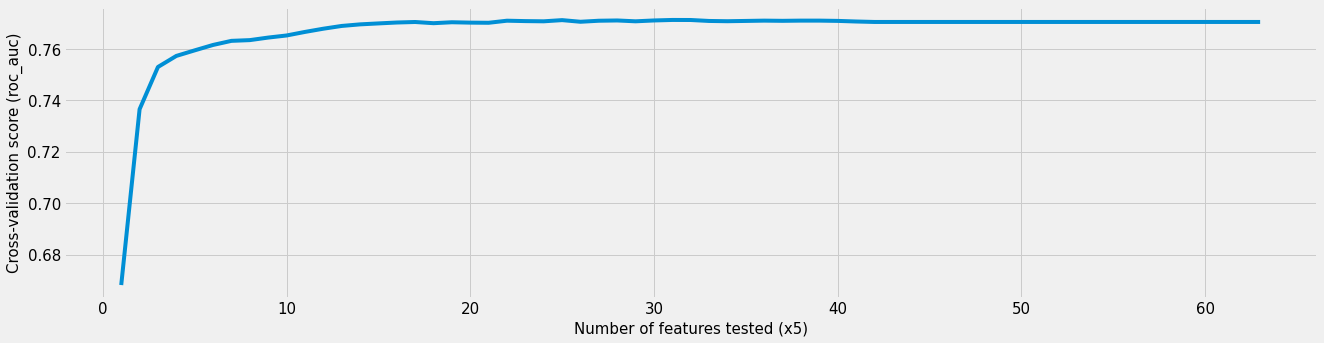

In [34]:
#Plot number of features vs CV scores
step=5
plt.figure(figsize=(20, 5))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.xlabel('Number of features tested (x%d)' % step)
plt.ylabel('Cross-validation score (roc_auc)')
show()

RFECV explique l'importance des features sélectionnées en fonction de l'évolution du score AUC, comme l'atteste également le plot ci-dessus.

In [35]:
#X_data is very important to implement the feature importance plot...
X_data = data_train.loc[:, data_train.columns[rfecv.get_support()]]
X_data.shape

(307511, 149)

Il est nécessaire de sauvegarder le dataset ``X_data`` de manière à pouvoir le réutiliser facilement…

In [47]:
#Merge operation with TARGET before save this reduced sample
X_data = X_data.merge(TARGET, left_index=True, right_index=True)

In [50]:
X_data.shape

(307511, 150)

In [51]:
%%time
compression_opts = dict(method='zip', archive_name='X_data.csv')
X_data.to_csv('/content/gdrive/My Drive/Colab Notebooks/p7_00_data/X_data.zip', index=True, compression=compression_opts)

CPU times: user 1min 14s, sys: 769 ms, total: 1min 15s
Wall time: 1min 15s


Nous allons sauvegarder deux jeux de données, le premier ci-dessus stocke la totalité des individus en rapport avec les 149 best features identifiées. Le second sera un échantillon permettant, si besoin, d'effectuer des tests plus rapidement, par exemple si l'utilité est nécessaire pour la conception de l'application.

In [52]:
%%time
compression_opts = dict(method='zip', archive_name='X_sample.csv')
X_data.sample(30000).to_csv('/content/gdrive/My Drive/Colab Notebooks/p7_00_data/X_sample.zip', index=True, compression=compression_opts)

CPU times: user 7.73 s, sys: 49.5 ms, total: 7.78 s
Wall time: 7.79 s


In [53]:
%%time
X_data.sample(10000).to_csv('/content/gdrive/My Drive/Colab Notebooks/p7_00_data/X_sample.csv', index=True)

CPU times: user 1.66 s, sys: 32.3 ms, total: 1.7 s
Wall time: 1.75 s


In [54]:
#Transform data with rfecv 
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)

In [57]:
def train_models(model, X_train_selected, X_test_selected, y_train, y_test):
    models = [
          #Ensemble methods
          CatBoostClassifier(task_type="GPU", logging_level='Silent'),
          LGBMClassifier(device='gpu'),
          XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor')
          ]

    model.fit(X_train_selected, y_train)
    output = {
      'AUC': roc_auc_score(y_test, model.predict_proba(X_test_selected)[:,1]),
      'Accuracy': accuracy_score(y_test, model.predict(X_test_selected)),
      'Precision': precision_score(y_test, model.predict(X_test_selected)),
      'Recall': recall_score(y_test, model.predict(X_test_selected)),
      'F1': f1_score(y_test, model.predict(X_test_selected))
      }
          
    return output

In [58]:
%%time

name = []
auc = []
accuracy = []
precision = []
recall = []
f1 = []
time_ = []

for model in models:
    start = time.time()
    results = train_models(model, X_train_selected, X_test_selected, y_train, y_test)

    name.append(type(model).__name__)
    auc.append(results['AUC'])
    accuracy.append(results['Accuracy'])
    precision.append(results['Precision'])
    recall.append(results['Recall'])
    f1.append(results['F1'])
    time_.append(time.time()-start)

#Initialise data of lists
models_rfe = pd.DataFrame(data=[name, auc, accuracy, precision, recall, f1, time_]).T
models_rfe.columns = ['Model', 'AUC', 'Accuracy', 'Precision', 'Recall', 'F1', 'Time']
models_rfe.sort_values('AUC', ascending=False, inplace=True)

CPU times: user 27.8 s, sys: 8.38 s, total: 36.2 s
Wall time: 24.7 s


In [59]:
#Models performance with features selection
models_rfe

,Model,AUC,Accuracy,Precision,Recall,F1,Time
1,LGBMClassifier,0.774652,0.920047,0.540481,0.0333198,0.06277,12.0603
0,CatBoostClassifier,0.774078,0.920025,0.544987,0.0285984,0.054345,9.96622
2,XGBClassifier,0.764208,0.919841,0.59375,0.00768919,0.0151818,2.67147


In [60]:
###Reminder before… features selection
base_models

,Model,AUC,Accuracy,Precision,Recall,F1,Time
1,LGBMClassifier,0.773782,0.920264,0.563758,0.0339943,0.0641221,10.7289
0,CatBoostClassifier,0.773559,0.920144,0.5625,0.0279239,0.0532065,133.957
2,XGBClassifier,0.764208,0.919841,0.59375,0.00768919,0.0151818,4.2202


**LGBMClassifier reste le modèle le plus performant selon le couple AUC score/Time.** CatBoostClassifier nécessite beaucoup plus de temps de calcul, il ne peut pas être retenu dans le contexte métier actuel. XGBClassifier est très rapide, il est en effet plus rapide que le LGBMClassifier mais avec une baisse de l'AUC score.

----
Dans la dernière partie de l'étude on développera les 3 volets suivants : **_La fonction coût, l'algorithme d'optimisation et la métrique d'évaluation._**

### **La fonction coût sera déterminée par l'analyse des erreurs de prédiction**

**FP (False Positive) :** les cas où la prédiction est positive, mais où la valeur réelle est négative. 

_Perte d'opportunité si le crédit client est refusé à tort, alors qu'il aurait été en mesure d'être remboursé._


**FN (False Negative) :** les cas où la prédiction est négative, mais où la valeur réelle est positive. 

_Perte réelle si le crédit client accepté se transforme en défaut de paiement._


**Ainsi, les pertes d'un crédit en raison d'une mauvaise classification dépendront des probabilités Faux Positifs et Faux Négatifs.**


L'idée est d'éviter les clients avec un fort risque de défaut. Il est donc nécessaire de pénaliser les FP et FN cités précédemment. Pour réduire ce rique de perte financière, il faut maximiser deux critères Recall et Precision.

\begin{aligned}{\text{Precision}}&={\frac {tp}{tp+fp}}\\{\text{Recall}}&={\frac {tp}{tp+fn}}\,\end{aligned}


Fonction qui optimise Precision et Recall avec une importance plus forte pour le critère Precision:
\begin{aligned}{\text{Fscore}}&={\frac {precision.recall}{Beta^2.precision + recall}}\,\end{aligned}



Avec Beta le coefficient d'importance relative au critère Precision par rapport au recall : 
\begin{aligned}{\text{Fscore}}&={\frac {precision.recall}{Beta^2.precision + recall}}\,&=(1+Beta^2) . {\frac {tp}{(1+Beta^2).tp + Beta^2.fn + fp}}\,\end{aligned}



_Explication sur la F-measure [Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)_


**L'application de cette métrique métier passe par la quantification de l'importance relative entre recall et précision, à savoir Beta (β).**
Cela revient à estimer le coût moyen d'un défaut, et le coût d'opportunité d'un client refusé par erreur. Cette connaissance métier n'est pas évoquée à ce stade du projet, nous allons donc l'estimer. Cette hypothèse pourra bien entendu être modifiée avec un interlocuteur métier.

- Défaut de paiement 30% du montant du crédit en pertes et autres frais de recouvrement.
- 10% de chance d'obtenir un crédit pour un client lambda qui souhaite emprunter.

\begin{aligned}{\text{Beta}}&={\frac {coef Recall}{coef Precision}}\end{aligned}\
On peut se fixer l'hypothèse d'un **Beta = 3**. Vérifions-le avec une étape de tests fonctionnels.



In [61]:
#Tests fonctionels avec des listes contenant 4 int: tp, tn, fp, fn
test_0 = [500, 300, 10, 30]
test_1 = [500, 300, 30, 10]
test_2 = [400, 300, 70, 50]
test_3 = [400, 300, 50, 70]
test_4 = [350, 250, 80, 120]
test_5 = [350, 250, 180, 90]

tests = [test_0, test_1, test_2, test_3, test_4, test_5]


def my_score(predictions_success: list) -> int:
    '''scoring fonction'''
    tp, tn, fp, fn = predictions_success
  
    beta = 3
    recall = tp / (tp + fn)
    precision = tp / (tp + fp) 
    fscore = (1+beta)*(tp / ((1+3)*tp + beta*fn + fp))
    
    return 1-fscore

for i, t in enumerate(tests):
    print("############################")
    print("Test", i, ":", t)
    print("Score :", my_score(t))

############################
Test 0 : [500, 300, 10, 30]
Score : 0.04761904761904767
############################
Test 1 : [500, 300, 30, 10]
Score : 0.029126213592232997
############################
Test 2 : [400, 300, 70, 50]
Score : 0.1208791208791209
############################
Test 3 : [400, 300, 50, 70]
Score : 0.13978494623655913
############################
Test 4 : [350, 250, 80, 120]
Score : 0.23913043478260865
############################
Test 5 : [350, 250, 180, 90]
Score : 0.2432432432432432


Les résultats sont satisfaisants, les risques liés aux erreurs de faux négatifs et positifs font ressortir un score plus importants, à l'inverse un dossier présentant moins de risque aura un score proche de zéro.

In [62]:
def custom_score(y_true, y_pred, beta=3) :
    '''function penalize fp and fn…'''
    tp, tn, fp, fn = confusion_matrix(y_true, y_pred).ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    fscore = (1+beta)*((tp / ((1+beta)*tp + beta*fn + fp)))

    return 1-fscore

In [63]:
def cost_false(model, y_true, X_true):
    '''Cost function analyzes prediction errors False Pos. and False Neg.'''
    cm = confusion_matrix(y_true, model.predict(X_true))
    FP = cm[0][1]/np.sum(cm)
    FN = cm[1][0]/np.sum(cm)
  
    print("False Pos: {0:.2%}".format(FP))
    print("False Neg: {0:.2%}".format(FN))
    return FP, FN

### **Hyperparameters tunning - Hyperopt et AUC score**
Choisir les hyperparamètres appropriés est nécessaire pour affiner et booster les performances d'un algorithme d’apprentissage automatique. La métrique utilisée dans le contexte de notre classification binaire sera l'AUC score.

Grid Search ou Random Search étaient également une alternative possible, à la différence d'Hyperopt une "méthode basique" ne permet pas de traiter un large espace de paramètres, ici très largement privilégié.


Avec Hyperopt, on peut facilement analyser notre modèle de Boosting tout en variant les hyperparamètres dans l'espace que nous allons définir ci-dessous. Hyperopt fonctionne avec les algorithmes de ML distribué, comme Apache Spark MLlib et Horovod, ainsi qu’avec les modèles ML mono-machine, comme scikit-learn et TensorFlow.

In [64]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

In [65]:
#Parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 600, 100),
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.03),
    'max_depth': hp.quniform('max_depth', 3, 7, 1),
    'subsample': hp.uniform('subsample', 0.60, 0.95),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.60, 0.95),
    'reg_lambda': hp.uniform('reg_lambda', 1, 20)
    }

In [66]:
def objective(params, eval_metric='custom_score'):
    #objective function to be minimized. 
    #Hyperopt will seek to minimize the loss returned by this function.
    
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'device':'gpu'
        }
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [67]:
%%time
best = fmin(fn=objective, space=space, max_evals=30, rstate=np.random.RandomState(1), algo=tpe.suggest)

100%|██████████| 30/30 [36:08<00:00, 72.28s/it, best loss: 0.9771273042187306]
CPU times: user 36min 4s, sys: 42.8 s, total: 36min 46s
Wall time: 36min 8s


In [68]:
%%time
lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    device='gpu')

lgbm.fit(X_train_selected, y_train)
pickle.dump(lgbm, open("/content/gdrive/My Drive/Colab Notebooks/p7_00_models/LGBMClassifier.pkl", "wb"))

CPU times: user 21.8 s, sys: 398 ms, total: 22.2 s
Wall time: 22.2 s


In [69]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.778292


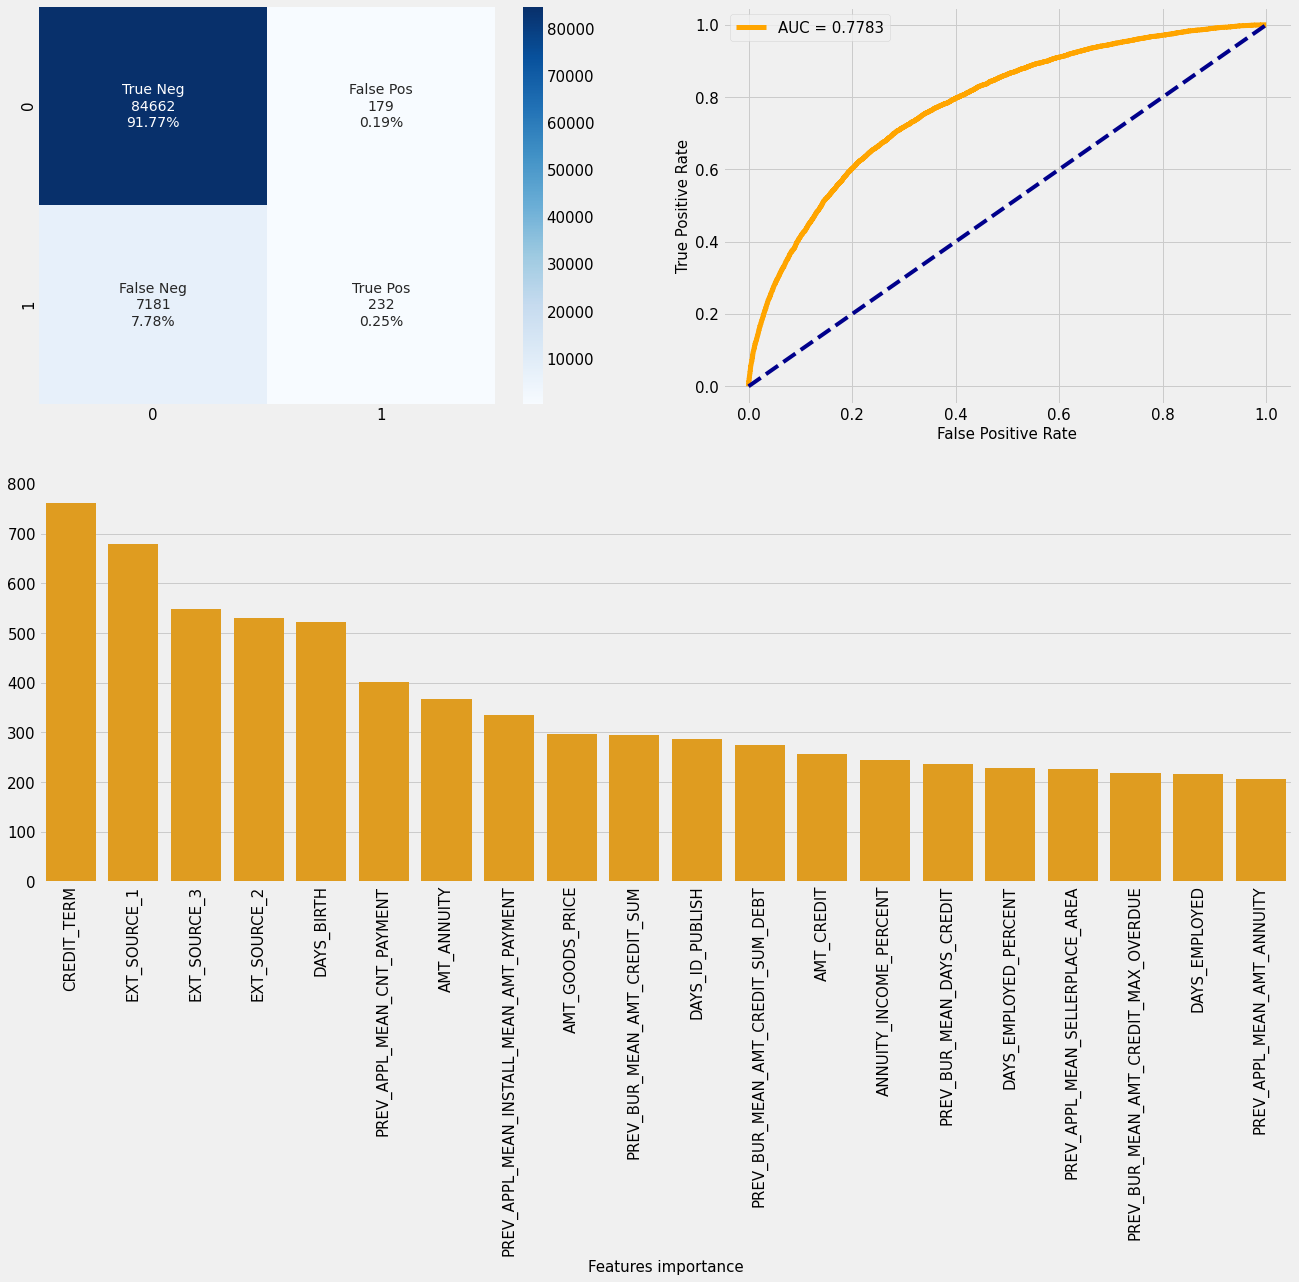

In [70]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], feature_importances=True)

In [71]:
#FP and FN
cost_false(lgbm, y_test, X_test_selected)

False Pos: 0.19%
False Neg: 7.78%


(0.0019402952717497343, 0.0778394432761723)

In [72]:
#Check list features importance 
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]]) 

['CREDIT_TERM', 762]
['EXT_SOURCE_1', 679]
['EXT_SOURCE_3', 548]
['EXT_SOURCE_2', 531]
['DAYS_BIRTH', 522]
['PREV_APPL_MEAN_CNT_PAYMENT', 401]
['AMT_ANNUITY', 368]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT', 336]
['AMT_GOODS_PRICE', 296]
['PREV_BUR_MEAN_AMT_CREDIT_SUM', 294]
['DAYS_ID_PUBLISH', 287]
['PREV_BUR_MEAN_AMT_CREDIT_SUM_DEBT', 275]
['AMT_CREDIT', 257]
['ANNUITY_INCOME_PERCENT', 244]
['PREV_BUR_MEAN_DAYS_CREDIT', 237]
['DAYS_EMPLOYED_PERCENT', 229]
['PREV_APPL_MEAN_SELLERPLACE_AREA', 227]
['PREV_BUR_MEAN_AMT_CREDIT_MAX_OVERDUE', 219]
['DAYS_EMPLOYED', 217]
['PREV_APPL_MEAN_AMT_ANNUITY', 206]
['PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT', 191]
['PREV_APPL_MEAN_INSTALL_MEAN_NUM_INSTALMENT_NUMBER', 190]
['DAYS_REGISTRATION', 188]
['PREV_APPL_MEAN_AMT_DOWN_PAYMENT', 187]
['PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT', 185]
['PREV_APPL_MEAN_DAYS_LAST_DUE_1ST_VERSION', 179]
['PREV_BUR_MEAN_DAYS_CREDIT_ENDDATE', 176]
['DAYS_LAST_PHONE_CHANGE', 174]
['PREVIOUS_LOANS_COUNT', 164]

In [85]:
def objective(params, eval_metric='roc_auc'):
  #objective function to be minimized. 
  #Hyperopt will seek to minimize the loss returned by this function.

    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': params['learning_rate'],
        'max_depth': int(params['max_depth']),
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'reg_lambda': params['reg_lambda'],
        'device':'gpu'}
  
    
    model= LGBMClassifier(**params)
    cv = StratifiedKFold(5)
    if eval_metric == 'roc_auc': 
        score = cross_val_score(model, X_train_selected, y_train, scoring='roc_auc', cv=cv).mean()

    elif eval_metric == 'custom_score': 
        y_pred = cross_val_predict(model, X_train_selected, y_train, method='predict', cv=cv)
        score = custom_score(y_train, y_pred)
  
    loss = 1 - score    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [86]:
%%time
best = fmin(fn=objective, space=space, max_evals=30, rstate=np.random.RandomState(1), algo=tpe.suggest)

100%|██████████| 30/30 [36:06<00:00, 72.21s/it, best loss: 0.22355147070039993]
CPU times: user 36min 1s, sys: 43.2 s, total: 36min 45s
Wall time: 36min 6s


In [87]:
%%time
lgbm = LGBMClassifier( #Fit a new model based on the best parameters
    n_estimators=int(best['n_estimators']), 
    colsample_bytree= best['colsample_bytree'],
    learning_rate= best['learning_rate'],
    max_depth= int(best['max_depth']),
    subsample= best['subsample'],
    reg_lambda= best['reg_lambda'],
    device='gpu')

lgbm.fit(X_train_selected, y_train)
#pickle.dump(lgbm, open("/content/gdrive/My Drive/Colab Notebooks/p7_00_models/LGBMClassifier.pkl", "wb"))

CPU times: user 23.2 s, sys: 405 ms, total: 23.7 s
Wall time: 23.2 s


In [88]:
roc_auc = roc_auc_score(y_test, lgbm.predict_proba(X_test_selected)[:,1])
print('AUC : %0.6f' %roc_auc)

AUC : 0.779233


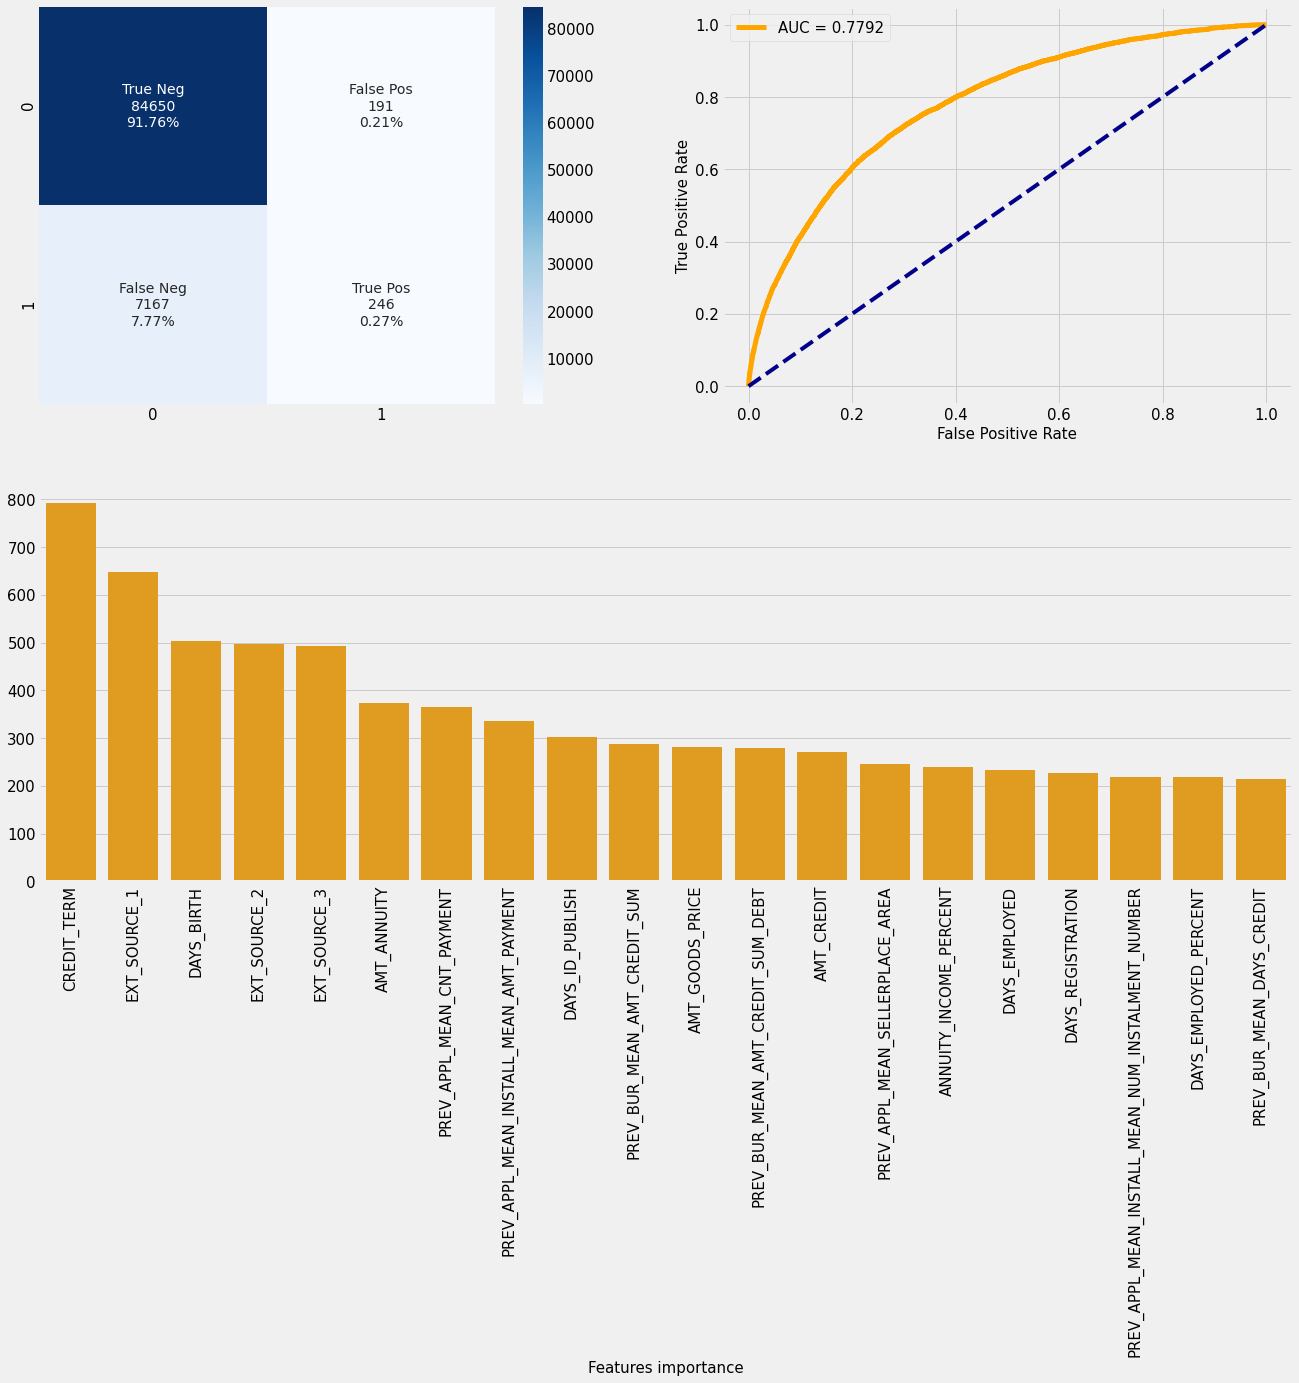

In [89]:
cf_matrix_roc_auc(lgbm, y_test, lgbm.predict(X_test_selected), lgbm.predict_proba(X_test_selected)[:,1], feature_importances=True)

In [90]:
#FP and FN
cost_false(lgbm, y_test, X_test_selected)

False Pos: 0.21%
False Neg: 7.77%


(0.002070370932425694, 0.07768768833871702)

In [ ]:
#Check list features importance 
sorted_idx = np.argsort(lgbm.feature_importances_)[::-1]
for index in sorted_idx:
    print([X_data.columns[index], lgbm.feature_importances_[index]]) 

**Conclusion**\
Après une baseline faite avec un algorithme simple de régression logistique, l'AUC score avait été estimé ≈ 0.72 avec rééquilibrage (SMOTE) des données. La suite de l'étude a été déroulée vers 3 algorithmes plus complexes de gradient boosting implémentés par LightGbm vs CatBoost vs XGBoost. Nous avons pu démontrer les performances de ces algorithmes par une sélection de features, à l'origine > 300, après RFECV 149. LightGbm ressort comme étant le plus rapide, le plus performant sur la métrique classique de l'AUC, il a donc été choisi pour l'optimisation des Hyperparamètres (Hyperopt).

La fonction coût permet de pénaliser les erreurs de prédiction qui peuvent coûter cher à l'entreprise. En effet, avec l'implémentation de la métrique métier les FP sont estimés à 0.19% (contre 0.21%), les FN sont à 0.78% (contre 0.77%). Au final la métrique métier permet de pénaliser légèrement mieux les erreurs du modèle.